In [ ]:
import os
from torch.utils.data import Dataset
import torch
import numpy as np


class CC200Data(Dataset):
    def __init__(self, region_path, subnet_path, mapping, labels):
        super().__init__()
        self.region_path = region_path
        self.subnet_path = subnet_path
        self.region_folder = os.listdir(self.region_path)
        self.subnet_folder = os.listdir(self.subnet_path)
        self.labels = self._map_labels(labels)
        self.region_indices = mapping
        self.region_coeff = torch.tensor([
            self._region_coeffs(np.load(f"{self.region_path}/{i}")) for i in self.region_folder
        ], dtype=torch.float32)
        self.subnetwork_coeff = [self._subnetwork_coeffs(i) for i in self.subnet_folder]
        self.region_start_indices = {}
        for i in range(1, 8):
            if i == 1:
                self.region_start_indices[i] = 0
            else:
                self.region_start_indices[i] = self.region_start_indices[i - 1] + len(
                    self.region_indices[(list(self.region_indices.keys())[i - 1])]
                )

    def _map_labels(self, mapping):
        labels = []
        for i in self.region_folder:
            if i[:-22] in mapping.keys():
                labels.append(mapping[i[:-22]])
            else:
                print(i)

        return torch.tensor(labels, dtype=torch.long)

    def _region_coeffs(self, x):
        b = np.zeros_like(x)
        y = 0
        for i in self.region_indices:
            b[:, y : y + len(self.region_indices[i])] = x[:, self.region_indices[i]]
            y += len(self.region_indices[i])
        
        return np.corrcoef(b, rowvar=False)

    def _subnetwork_coeffs(self, x):
        data = np.load(x)
        arrays = [data[key] for key in data.files]
        correlation_matrices = [self._flatten_matrix(i) for i in arrays]
        return correlation_matrices

    def _flatten_matrix(self, matrix):
        idx = np.triu_indices_from(matrix, k=1)
        return matrix[idx]

    def __len__(self):
        return len(self.region_folder)

    def __getitem__(self, idx):
        region_corr = self.region_coeff[idx]
        subnetwork_corrs = self.subnetwork_coeff[idx]
        labels = self.labels[idx]
        return region_corr, subnetwork_corrs, labels

In [81]:
# !wget https://raw.githubusercontent.com/broccubali/AutisticAdventures/main/cc200_to_yeo7_mapping.csv
# !wget https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv

In [82]:
import json

with open("mapping.json", "r") as f:
    mapping = json.load(f)

In [83]:
import pandas as pd
df = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")
df = df[["FILE_ID", "DX_GROUP"]]
labels_mapping = dict(zip(df["FILE_ID"], df["DX_GROUP"]))

In [84]:
# !ls /kaggle/input

In [85]:
# had to fix this here cuz pytorch cross entropy loss needs 0 and 1 not 1 and 2
new_labels_mapping = {}
for key, value in labels_mapping.items():
    new_labels_mapping[key] = value - 1  # Subtract 1 to convert 1,2 to 0,1

# Recreate your dataset with adjusted labels
dataset = CC200Data("region_corr", "subnet_corr", mapping, new_labels_mapping)

In [86]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [36]:
unique_labels = set()
for _, _, labels in train_loader:
    unique_labels.update(labels.numpy())
print(f"updated label values: {sorted(list(unique_labels))}")

updated label values: [0, 1]


In [58]:
shapes = []
a = next(iter(dataset))[1]
for i in a:
    shapes.append(i.shape[0])

# len(shapes)

IndexError: tuple index out of range

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHSA(nn.Module):
    def __init__(self, embd_dim, num_heads):
        super().__init__()
        self.embd_dim = embd_dim
        self.num_heads = num_heads
        self.head_size = self.embd_dim // self.num_heads
        self.q = nn.Linear(self.embd_dim, self.embd_dim)
        self.k = nn.Linear(self.embd_dim, self.embd_dim)
        self.v = nn.Linear(self.embd_dim, self.embd_dim)
        self.d = self.head_size ** 0.5
        self.mlp = nn.Linear(self.embd_dim, self.embd_dim)
        self.layer_norm = nn.LayerNorm(self.embd_dim)  
        
    def forward(self, x):
        batch_size, M, _ = x.shape
        norm = self.layer_norm(x)
        q = self.q(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        k = self.k(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        v = self.v(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / self.d
        attn_scores = attn_scores.masked_fill(torch.eye(M, device=x.device).bool(), float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, v).transpose(1, 2).reshape(batch_size, M, self.embd_dim)
        out = self.mlp(context)
        return out + x, attn_weights

In [60]:
class SubnetworkEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.mlp(x)

In [61]:
class RegionEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.region_conv = nn.Conv2d(1, 1, kernel_size=5)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim - 4, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )       

    def forward(self, x):
        x_conv = self.region_conv(x.unsqueeze(1)) 
        x_conv = x_conv.squeeze(1)  
        print(x_conv.shape)
        return self.mlp(x_conv)

In [62]:
class RegionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.reg_embd = RegionEmbedder(input_dim, hidden_dim, embd_dim)
        self.mhsa_layers = nn.ModuleList([MHSA(embd_dim, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        x_reg = self.reg_embd(x)
        # x_in = x_reg
        # attn_weights_all = []
        # for mhsa in self.mhsa_layers:
        #     x_in, attn_weights = mhsa(x_in)
        #     attn_weights_all.append(attn_weights)
        # +x_in, torch.stack(attn_weights_all)
        return x_reg

In [40]:
class SubNetworkEncoder(nn.Module):
    def __init__(self, shapes, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.embd_dim = embd_dim
        self.mlps = nn.ModuleList([SubnetworkEmbedder(i, hidden_dim, embd_dim) for i in shapes])
        self.mhsa_layers = nn.ModuleList([MHSA(embd_dim, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        x = torch.stack([mlp(f) for mlp, f in zip(self.mlps, x)], dim=1)
        attn_weights_all = []
        for mhsa in self.mhsa_layers:
            x, attn_weights = mhsa(x)
            attn_weights_all.append(attn_weights)

        return x, torch.stack(attn_weights_all)

In [15]:
class StepOne(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.reg_enc = RegionEncoder(input_dim, hidden_dim, embd_dim, num_heads, num_layers)
        self.subnet_enc = SubNetworkEncoder(shapes, hidden_dim, embd_dim, num_heads, num_layers)
        self.layer_norm = nn.LayerNorm(embd_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embd_dim, hidden_dim),  
            nn.ReLU(),             
            nn.Linear(hidden_dim, embd_dim)    
        )
        self.region_start_indices = list(dataset.region_start_indices.values()) + [185]

    def subNetworkAttendRegions(self, subnet_attn_map, region_attn_map):
        region_to_subnet = torch.zeros(185, dtype=torch.long)
        for subnet_id in range(7):
            start = self.region_start_indices[subnet_id]
            end = self.region_start_indices[subnet_id + 1]
            region_to_subnet[start:end] = subnet_id  
        subnet_i = region_to_subnet.view(-1, 1).expand(185, 185) 
        subnet_j = region_to_subnet.view(1, -1).expand(185, 185)  

        mask = subnet_i != subnet_j  

        attn_multiplier = subnet_attn_map[:, :, :, subnet_i, subnet_j]  
        attn_multiplier = attn_multiplier * mask

        return region_attn_map * attn_multiplier 
    
    def sinkhorn(self, attn, n_iters=5, eps=1e-6):
        attn = attn + eps  
        for _ in range(n_iters):
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn / attn.sum(dim=-2, keepdim=True)
        return attn
    
    def forward(self, x):
        x0 = self.reg_enc(x[0])
        x1 = self.subnet_enc(x[1])
        o = torch.cat((x0[0], x1[0]), dim=1)
        o_norm = self.layer_norm(o)
        o_norm = self.mlp(o)
        o = o + o_norm
        print(o.shape)
        o_reg = o[:, :185, :]
        o_sub = o[:, 185:, :]
        adj_matrix = self.subNetworkAttendRegions(x1[1], x0[1])
        adj_matrix = self.sinkhorn(adj_matrix)
        return o_reg, o_sub, adj_matrix

# HGCN part now

In [16]:
class HGCN(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers=4, num_heads=16):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.num_heads = num_heads

        # One linear layer per head per layer: (L, H, in, out)
        self.W = nn.Parameter(torch.randn(num_layers, num_heads, input_dim, output_dim))
        self.activation = nn.ReLU()

    def forward(self, features, attention_maps):
        """
        features: [B, N, F_in]
        attention_maps: [B, L, H, N, N] — soft adjacency or incidence maps
        """
        B, L, H, N, _ = attention_maps.shape
        F_in, F_out = self.input_dim, self.output_dim

        # Apply W to input features: [B, 1, 1, N, F_in] x [L, H, F_in, F_out]
        # -> output: [B, L, H, N, F_out]
        features_exp = features[:, None, None, :, :]  # [B, 1, 1, N, F_in]
        weights = self.W[None, :, :, :, :]            # [1, L, H, F_in, F_out]
        transformed = torch.matmul(features_exp, weights)  # [B, L, H, N, F_out]

        # Apply hypergraph attention maps
        # attention_maps: [B, L, H, N, N]
        # transformed:     [B, L, H, N, F_out]
        output = torch.matmul(attention_maps, transformed)  # [B, L, H, N, F_out]
        output = self.activation(output)

        # Concatenate heads → [B, L, N, H * F_out]
        output = output.permute(0, 1, 3, 2, 4).reshape(B, L, N, H * F_out)

        # Concatenate layers → [B, N, L * H * F_out]
        output = output.permute(0, 2, 1, 3).reshape(B, N, L * H * F_out)

        return output

In [21]:
class StepOneWithHGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers, num_classes=2):
        super().__init__()
        # Copy paste
        self.reg_enc = RegionEncoder(input_dim, hidden_dim, embd_dim, num_heads, num_layers)
        self.subnet_enc = SubNetworkEncoder(shapes, hidden_dim, embd_dim, num_heads, num_layers)
        self.layer_norm = nn.LayerNorm(embd_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embd_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embd_dim)
        )
        self.region_start_indices = list(dataset.region_start_indices.values()) + [185]
        self.hgcn = HGCN(input_dim=embd_dim, output_dim=embd_dim//num_heads)
        hgcn_output_dim = (embd_dim//num_heads) * num_heads * num_layers
        self.classifier = nn.Sequential(
            nn.Linear(hgcn_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def subNetworkAttendRegions(self, subnet_attn_map, region_attn_map):
        region_to_subnet = torch.zeros(185, dtype=torch.long)
        for subnet_id in range(7):
            start = self.region_start_indices[subnet_id]
            end = self.region_start_indices[subnet_id + 1]
            region_to_subnet[start:end] = subnet_id
        subnet_i = region_to_subnet.view(-1, 1).expand(185, 185)
        subnet_j = region_to_subnet.view(1, -1).expand(185, 185)
        mask = subnet_i != subnet_j
        attn_multiplier = subnet_attn_map[:, :, :, subnet_i, subnet_j]
        mask = mask.to("cuda")
        attn_multiplier = attn_multiplier * mask
        return region_attn_map * attn_multiplier
    
    def sinkhorn(self, attn, n_iters=5, eps=1e-6):
        attn = attn + eps
        for _ in range(n_iters):
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn / attn.sum(dim=-2, keepdim=True)
        return attn
    
    def forward(self, x):
        x0, region_attn = self.reg_enc(x[0])
        x1, subnet_attn = self.subnet_enc(x[1])

        o = torch.cat((x0, x1), dim=1)
        o_norm = self.layer_norm(o)
        o_norm = self.mlp(o_norm)
        o = o + o_norm
        o_reg = o[:, :185, :]  # First 185 nodes are regions
        o_sub = o[:, 185:, :]  # Remaining nodes are subnetworks
        # Process attention maps to create the combined attention 
        # with shape [batch_size, num_layers (4), num_heads (16), 185, 185]
        combined_attn = self.subNetworkAttendRegions(subnet_attn, region_attn)
        combined_attn = self.sinkhorn(combined_attn)
        
        # Pass through HGCN - only process the region features with the combined attention
        hgcn_output = self.hgcn(o_reg, combined_attn)
        # Global average pooling for classification
        pooled_output = hgcn_output.mean(dim=1)  # [batch_size, output_dim*num_heads*num_layers]
        # Final classif
        logits = self.classifier(pooled_output)
        return logits

In [24]:
from tqdm import tqdm

model = StepOneWithHGCN(
    input_dim=185,
    hidden_dim=256,
    embd_dim=128,
    num_heads=16,
    num_layers=4,
    num_classes=2
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm for batch progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (region_data, subnetwork_data, labels) in pbar:
        region_data = region_data.to(device)
        subnetwork_data = [subnet.to(device) for subnet in subnetwork_data]
        labels = labels.to(device)

        optimizer.zero_grad()

        x = (region_data, subnetwork_data)
        logits = model(x)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{running_loss / (batch_idx + 1):.4f}',
            'Acc': f'{100 * correct / total:.2f}%'
        })

torch.save(model.state_dict(), 'brain_network_model.pth')


Epoch 50/50: 100%|██████████| 56/56 [00:10<00:00,  5.43it/s, Loss=0.6895, Acc=53.39%]


In [87]:
a = next(iter(train_loader))[0]

In [88]:
mlps = RegionEncoder(100, 256, 128, 16, 4)
x = mlps(a)

torch.Size([16, 96, 96])


In [89]:
a[0]

tensor([[1.0000, 0.3507, 0.2966,  ..., 0.1942, 0.4456, 0.3097],
        [0.3507, 1.0000, 0.7635,  ..., 0.3302, 0.4905, 0.0527],
        [0.2966, 0.7635, 1.0000,  ..., 0.3759, 0.7890, 0.2779],
        ...,
        [0.1942, 0.3302, 0.3759,  ..., 1.0000, 0.5824, 0.7070],
        [0.4456, 0.4905, 0.7890,  ..., 0.5824, 1.0000, 0.6153],
        [0.3097, 0.0527, 0.2779,  ..., 0.7070, 0.6153, 1.0000]])

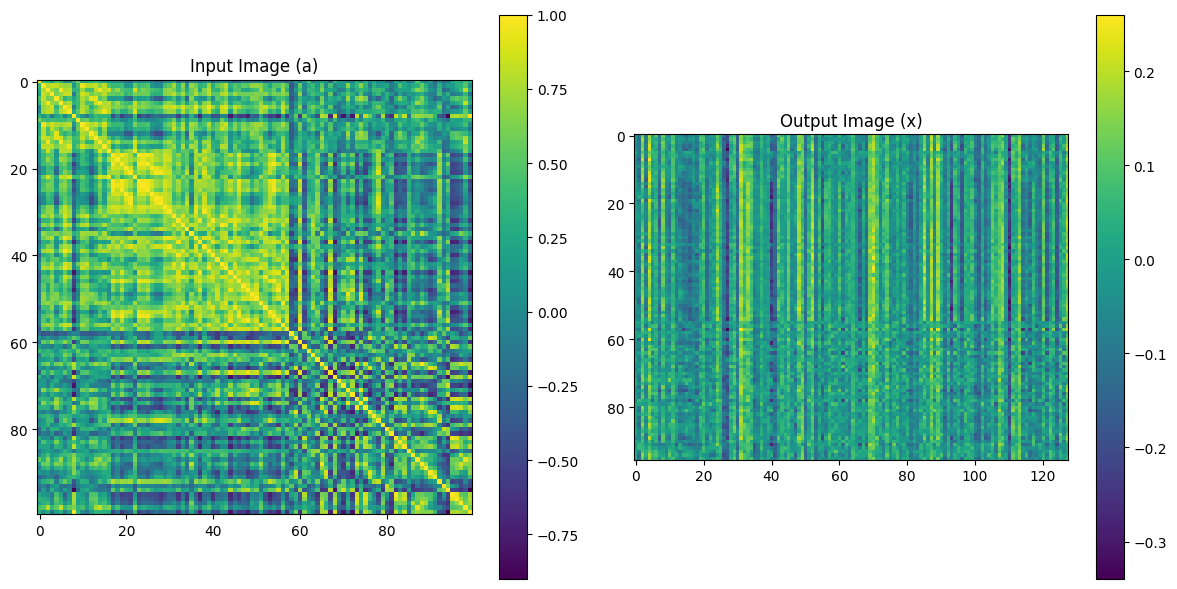

In [90]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(a[0].detach().cpu().numpy(), cmap="viridis")
axes[0].set_title("Input Image (a)")
axes[0].colorbar = plt.colorbar(
    axes[0].imshow(a[0].detach().cpu().numpy(), cmap="viridis"), ax=axes[0]
)

axes[1].imshow(x[0].detach().cpu().numpy(), cmap="viridis")
axes[1].set_title("Output Image (x)")
axes[1].colorbar = plt.colorbar(
    axes[1].imshow(x[0].detach().cpu().numpy(), cmap="viridis"), ax=axes[1]
)

plt.tight_layout()
plt.show()